# Pix2Pix Overview 

## 1. Generator: U-Net 

UNet architechtures are widely used in semantic segmentation tasks. 

### Pixel Distance Loss

The Pixel Distance Loss is a regularization term added to the GAN generator BCE loss function. The regularization term calculates the difference between the fake image and the target real image. With the addition of Pixel Distance, we encourage the output image look more similar to the target real image.    

## 2. Discriminator: PatchGAN 

Pix2Pix discriminator is a technique called PatchGAN. PatchGAN outputs a matrix of classifications intead of a single output. Each value in the classification matrix are between 0 and 1, with 0 representing fake and 1 real. With a predicted probability for each patch, it helps give localized feedback on the realness of each patch. 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time, pickle, json 
from glob import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict
from statistics import mean 
from tqdm import tqdm 

import torch 
import torch.nn as nn 
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader 

In [22]:
MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)
RESIZE = 64

def read_path(filepath) -> List[str]:
    root_path = "..\\..\\..\\pix2pix\\pytorch-CycleGAN-and-pix2pix\\datasets\\facades"
    path = os.path.join(root_path, filepath)
    dataset = []
    for p in glob(path+"/"+"*.jpg"):
        dataset.append(p)
    return dataset 


class Transform():
    def __init__(self, resize=RESIZE, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([
            transforms.Resize((resize, resize)), 
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)

    
class Dataset(object):
    def __init__(self, files: List[str]):
        self.files = files 
        self.trasformer = Transform()
        
    def _separate(self, img) -> Tuple[Image.Image, Image.Image]:
        img = np.array(img, dtype=np.uint8)
        h, w, _ = img.shape
        w = int(w/2)
        return Image.fromarray(img[:, w:, :]), Image.fromarray(img[:, :w, :])
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = Image.open(self.files[idx])
        input, output = self._separate(img)
        input_tensor = self.trasformer(input)
        output_tensor = self.trasformer(output)
        return input_tensor, output_tensor 
    
    def __len__(self):
        return len(self.files)
    
   

In [23]:
train = read_path("train")
val = read_path("val")
train_ds = Dataset(train)
val_ds = Dataset(val) 

In [7]:
def clamp_image(img: torch.Tensor):
    img = ((img.clamp(min=-1, max=1)+1)/2).permute(1, 2, 0)
    return img 

In [8]:
def show_img_sample(img: torch.Tensor, img1: torch.Tensor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    ax = axes.ravel()
    ax[0].imshow(clamp_image(img))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("label image", c="g")
    ax[1].imshow(clamp_image(img1))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("input image", c="g")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show() 

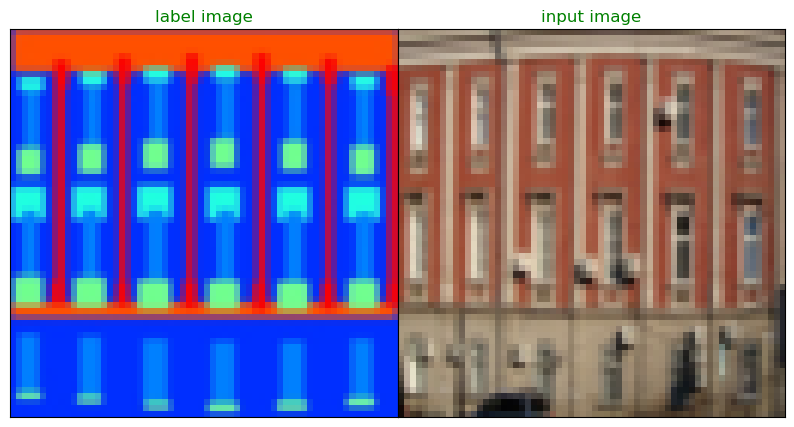

In [9]:
show_img_sample(train_ds.__getitem__(1)[0], train_ds.__getitem__(1)[1])

## Setup DataLoader 

In [10]:

BATCH_SIZE = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
np.random.seed(0)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [28]:
device

'cuda'

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 = self.conv2Relu(3, 32, 5)
        self.enc2 = self.conv2Relu(32, 64, pool_size=4)
        self.enc3 = self.conv2Relu(64, 128, pool_size=2)
        self.enc4 = self.conv2Relu(128, 256, pool_size=2)
        
        self.dec1 = self.deconv2Relu(256, 128, pool_size=2)
        self.dec2 = self.deconv2Relu(128+128, 64, pool_size=2)
        self.dec3 = self.deconv2Relu(64+64, 32, pool_size=4)
        self.dec4 = nn.Sequential(
            nn.Conv2d(32+32, 3, 5, padding=2), 
            nn.Tanh()
        )
        
    def conv2Relu(self, in_c, out_c, kernel_size=3, pool_size=None):
        layer = []
        if pool_size:
            # Down width and height
            layer.append(nn.AvgPool2d(pool_size))
        # Up channel size 
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, 
                               padding=(kernel_size-1)//2))
        layer.append(nn.LeakyReLU(0.2, inplace=True))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)
    
    def deconv2Relu(self, in_c, out_c, kernel_size=3, 
                    stride=1, pool_size=None):
        layer = []
        if pool_size:
            # Up width and height
            layer.append(nn.UpsamplingNearest2d(
                scale_factor=pool_size))
        # Down channel size 
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, 
                               stride, padding=1))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)
    
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3) # (b, 256, 4, 4)
        
        out = self.dec1(x4)
        # concat channel
        out = self.dec2(torch.cat((out, x3), dim=1))  
        out = self.dec3(torch.cat((out, x2), dim=1))
        out = self.dec4(torch.cat((out, x1), dim=1)) 
        return out # (b, 3, 64, 64)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = self.conv2relu(6, 16, 5, cnt=1)
        self.layer2 = self.conv2relu(16, 32, pool_size=4)
        self.layer3 = self.conv2relu(32, 64, pool_size=2)
        self.layer4 = self.conv2relu(64, 128, pool_size=2)
        self.layer5 = self.conv2relu(128, 256, pool_size=2)
        self.layer6 = nn.Conv2d(256, 1, kernel_size=1)
        
    def conv2relu(self, in_c, out_c, kernel_size=3, pool_size=None, cnt=2):
        layer = []
        for i in range(cnt):
            if i == 0 and pool_size != None:
                # Down width and height 
                layer.append(nn.AvgPool2d(pool_size))
            # Down channel size 
            layer.append(nn.Conv2d(in_c if i == 0 else out_c, 
                                   out_c,
                                   kernel_size,
                                   padding=(kernel_size-1)//2))
            layer.append(nn.BatchNorm2d(out_c))
            layer.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layer)
        
    def forward(self, x, x1):
        x = torch.cat((x, x1), dim=1)
        out = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return self.layer6(out) # (b, 1, 2, 2)        

In [18]:
def train_fn(train_dl, G, D, criterion_bce, criterion_mae, 
             optimizer_g, optimizer_d):
    G.train()
    D.train()
    LAMBDA = 100.0
    total_loss_g, total_loss_d = [], []
    for i, (input_img, real_img) in enumerate(tqdm(train_dl)):
        input_img = input_img.to(device)
        real_img = real_img.to(device)
        
        real_label = torch.ones(input_img.size()[0], 1, 2, 2)
        fake_label = torch.zeros(input_img.size()[0], 1, 2, 2)
        
        # generator 
        fake_img = G(input_img)
        fake_img_ = fake_img.detach().cpu() 
        out_fake = D(fake_img, input_img).cpu() 
        loss_g_bce = criterion_bce(out_fake, real_label) 
        loss_g_mae = criterion_mae(fake_img, real_img) 
        loss_g = loss_g_bce + LAMBDA * loss_g_mae 
        total_loss_g.append(loss_g.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        
        # discriminator  
        out_real = D(real_img.to(device), input_img.to(device)) 
        loss_d_real = criterion_bce(out_real.to(device), 
                                    real_label.to(device))
        out_fake = D(fake_img_.to(device), input_img)
        loss_d_fake = criterion_bce(out_fake.to(device), 
                                    fake_label.to(device))
        loss_d = loss_d_real + loss_d_fake 
        total_loss_d.append(loss_d.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    return mean(total_loss_g), mean(total_loss_d), fake_img.detach().cpu() 

def saving_img(fake_img, e):
    os.makedirs("generated", exist_ok=True)
    save_image(fake_img, f"generated/fake{str(e)}.png", value_range=(-1.0, 1.0)
               , normalize=True)
    
def saving_logs(result):
    with open("train.pkl", "wb") as f:
        pickle.dump([result], f)
        
def saving_model(D, G, e):
    os.makedirs("weight", exist_ok=True)
    torch.save(G.state_dict(), f"weight/G{str(e+1)}.pth")
    torch.save(D.state_dict(), f"weight/D{str(e+1)}.pth")
        
def show_losses(g, d):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax = axes.ravel()
    ax[0].plot(np.arange(len(g)).tolist(), g)
    ax[0].set_title("Generator Loss")
    ax[1].plot(np.arange(len(d)).tolist(), d)
    ax[1].set_title("Discriminator Loss")
    plt.show()

In [19]:
def train_loop(train_dl, G, D, num_epoch, lr=0.0002, betas=(0.5, 0.999)):
    G.to(device)
    D.to(device)
    optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
    optimizer_d = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)
    criterion_mae = nn.L1Loss()
    criterion_bce = nn.BCEWithLogitsLoss()
    total_loss_d, total_loss_g = [], []
    result = {}
    
    for e in range(num_epoch):
        loss_g, loss_d, fake_img = train_fn(train_dl, G, D, criterion_bce
                                , criterion_mae, optimizer_g, optimizer_d)
        total_loss_d.append(loss_d)
        total_loss_g.append(loss_g)
        saving_img(fake_img, e+1)
        
        if e%10 == 0:
            saving_model(D, G, e)
    try:
        result["G"] = total_loss_d 
        result["D"] = total_loss_g 
        saving_logs(result)
        show_losses(total_loss_g, total_loss_d)
        saving_model(D, G, e)
        print("successfully save model")
    finally:
        return G, D 
    


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.19it/s]


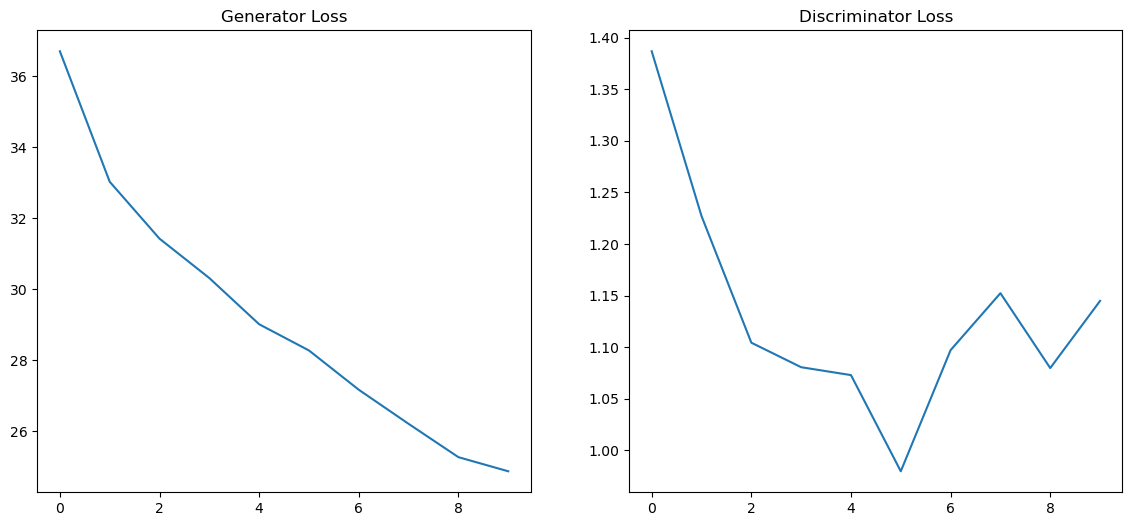

successfully save model


In [20]:
G = Generator()
D = Discriminator()
EPOCH = 10 
trained_G, trained_D = train_loop(train_dl, G, D, EPOCH)

In [24]:
def load_model(name):
    G = Generator()
    G.load_state_dict(torch.load(f"weight/G{name}.pth", 
                                 map_location={"cuda": "cpu"}))
    G.eval()
    return G.to(device)

def train_show_img(name, G):
    root = "generated"
    fig, axes = plt.subplots(int(name), 1, figsize=(12, 18))
    ax = axes.ravel()
    for i in range(int(name)):
        filename = os.path.join(root, f"fake{str(i+1)}.png")
        ax[i].imshow(Image.open(filename))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

def de_norm(img):
    img_ = img.mul(torch.FloatTensor(STD).view(3, 1, 1))
    img_ = img_.add(torch.FloatTensor(MEAN).view(3, 1, 1)).detach()
    # img_ = ((img_.clamp(min=-1, max=1)+1)/2).permute(1, 2, 0)
    img_ = img_.clamp(min=-1, max=1).permute(1, 2, 0)
    return img_.numpy() 

def evaluate(val_dl, name, G):
    with torch.no_grad():
        fig, axes = plt.subplots(6, 8, figsize=(12, 12))
        ax = axes.ravel()
        for input_img, real_img in tqdm(val_dl):
            input_img = input_img.to(device)
            real_img = real_img.to(device)
            
            fake_img = G(input_img)
            batch_size = input_img.size()[0]
            batch_size_2 = batch_size * 2 
            
            for i in range(batch_size):
                ax[i].imshow(de_norm(input_img[i].cpu()))
                ax[i+batch_size].imshow(de_norm(real_img[i].cpu()))
                ax[i+batch_size_2].imshow(de_norm(fake_img[i].cpu()))
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                ax[i+batch_size].set_xticks([])
                ax[i+batch_size].set_yticks([])
                ax[i+batch_size_2].set_xticks([])
                ax[i+batch_size_2].set_yticks([])
                if i == 0:
                    ax[i].set_ylabel("Input Image", c="g")
                    ax[i+batch_size].set_ylabel("Real Image", c="g")
                    ax[i+batch_size_2].set_ylabel("Generated Image", c="r")
            plt.subplots_adjust(wspace=0, hspace=0)
            break   

In [29]:

# train_show_img(5, trained_G)

In [30]:

# evaluate(val_dl, 5, trained_G)